<div style="background-color:#5D73F2; color:#19180F; font-size:40px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> Beginner Friendly Approaches </div>
<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
1. Random Forest Regressor with K-Fold CV and Optuna</div>

<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> Importing modules </div>

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import optuna
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> Loading data</div>

In [2]:
train_data = pd.read_csv('/kaggle/input/dissolved-oxygen-prediction-in-river-water/train.csv')
test_data = pd.read_csv('/kaggle/input/dissolved-oxygen-prediction-in-river-water/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e21/sample_submission.csv')

<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> Displaying the first few rows of the training data</div>

In [3]:

train_data.head() 


,Id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,12.58,9.875,9.20,NaN,NaN,NaN,NaN,NaN,0.690,...,NaN,NaN,NaN,4.80,5.850,NaN,NaN,NaN,NaN,NaN
1,3,9.37,10.300,10.75,NaN,NaN,NaN,NaN,NaN,0.710,...,NaN,NaN,NaN,5.88,6.835,NaN,NaN,NaN,NaN,NaN
2,4,8.35,8.290,7.90,NaN,NaN,NaN,NaN,NaN,2.210,...,NaN,NaN,NaN,3.20,2.700,NaN,NaN,NaN,NaN,NaN
3,5,9.57,8.820,6.80,NaN,NaN,NaN,NaN,NaN,0.595,...,NaN,NaN,NaN,7.70,7.055,NaN,NaN,NaN,NaN,NaN
4,6,6.00,6.000,6.50,NaN,NaN,NaN,NaN,NaN,0.600,...,NaN,NaN,NaN,5.50,5.300,NaN,NaN,NaN,NaN,NaN


<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">  Summary of the training data
</div>

In [4]:
train_data.describe() 

,Id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
count,147.000000,147.000000,145.000000,145.000000,32.000000,31.000000,33.000000,37.000000,37.000000,145.000000,...,33.000000,37.000000,37.000000,145.000000,145.000000,32.000000,31.000000,33.000000,37.000000,37.000000
mean,101.401361,9.211497,9.168506,9.148126,10.002813,8.483226,6.095152,9.396892,7.598243,0.588168,...,6.982515,3.373689,3.200135,4.972724,4.906379,4.665312,5.871935,8.678788,3.884054,3.957703
std,64.836640,2.886614,4.188197,3.746898,2.667096,2.527239,3.279915,2.848153,3.409060,0.462262,...,4.466642,2.823756,2.868225,2.044057,2.001381,2.057903,2.555560,5.299039,1.615542,1.916813
min,0.000000,1.900000,2.200000,2.200000,4.660000,4.900000,0.000000,0.000000,0.000000,0.040000,...,0.670000,0.100000,0.000000,0.900000,1.040000,2.040000,2.480000,2.880000,1.000000,1.600000
25%,41.500000,7.375000,7.050000,7.200000,8.100000,6.865000,3.290000,8.800000,6.170000,0.230000,...,4.100000,1.440000,1.610000,3.500000,3.400000,3.325000,4.445000,5.840000,2.900000,2.900000
50%,102.000000,8.800000,8.700000,8.566667,9.522500,7.800000,5.800000,9.805000,7.150000,0.425000,...,6.050000,2.650000,1.900000,4.800000,4.833333,4.150000,5.500000,7.300000,3.400000,3.500000
75%,158.500000,10.850000,10.600000,10.500000,11.611250,9.232500,9.500000,10.440000,8.700000,0.800000,...,8.550000,4.320000,3.800000,6.450000,6.200000,5.970000,6.400000,8.415000,4.800000,4.400000
max,214.000000,19.100000,46.950000,40.900000,15.900000,15.400000,11.800000,13.700000,15.900000,2.400000,...,20.050000,10.200000,13.300000,10.900000,11.000000,10.665000,14.790000,27.120000,8.540000,10.370000


<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">  Checking for missing values
</div>

In [5]:
train_data.isnull().sum()


Id          0
target      0
O2_1        2
O2_2        2
O2_3      115
O2_4      116
O2_5      114
O2_6      110
O2_7      110
NH4_1       2
NH4_2       2
NH4_3     115
NH4_4     116
NH4_5     114
NH4_6     110
NH4_7     110
NO2_1       2
NO2_2       2
NO2_3     115
NO2_4     116
NO2_5     114
NO2_6     110
NO2_7     110
NO3_1       2
NO3_2       2
NO3_3     115
NO3_4     116
NO3_5     114
NO3_6     110
NO3_7     110
BOD5_1      2
BOD5_2      2
BOD5_3    115
BOD5_4    116
BOD5_5    114
BOD5_6    110
BOD5_7    110
dtype: int64

<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">  Custom correlation matrix plot
</div>

In [6]:
def plot_heatmap(df, title):
    # Create a mask for the top half of the matrix
    mask = np.triu(np.ones_like(df.corr()))

    # Set the colormap and figure size
    colormap = sns.cubehelix_palette(n_colors=15, start=.46, rot=-.45, dark=.2, hue=0.95, as_cmap=True)
    plt.figure(figsize=(25, 25))

    # Set the title and font properties
    plt.title(f'Correlation of Features in {title}', fontweight='bold', y=1.02, size=20)

    # Plot the heatmap with the masked upper triangle
    sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, vmin=-1.0,
                square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 10, "weight": "bold"},
                mask=mask)


<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">  Plotting correlation matrix
</div>

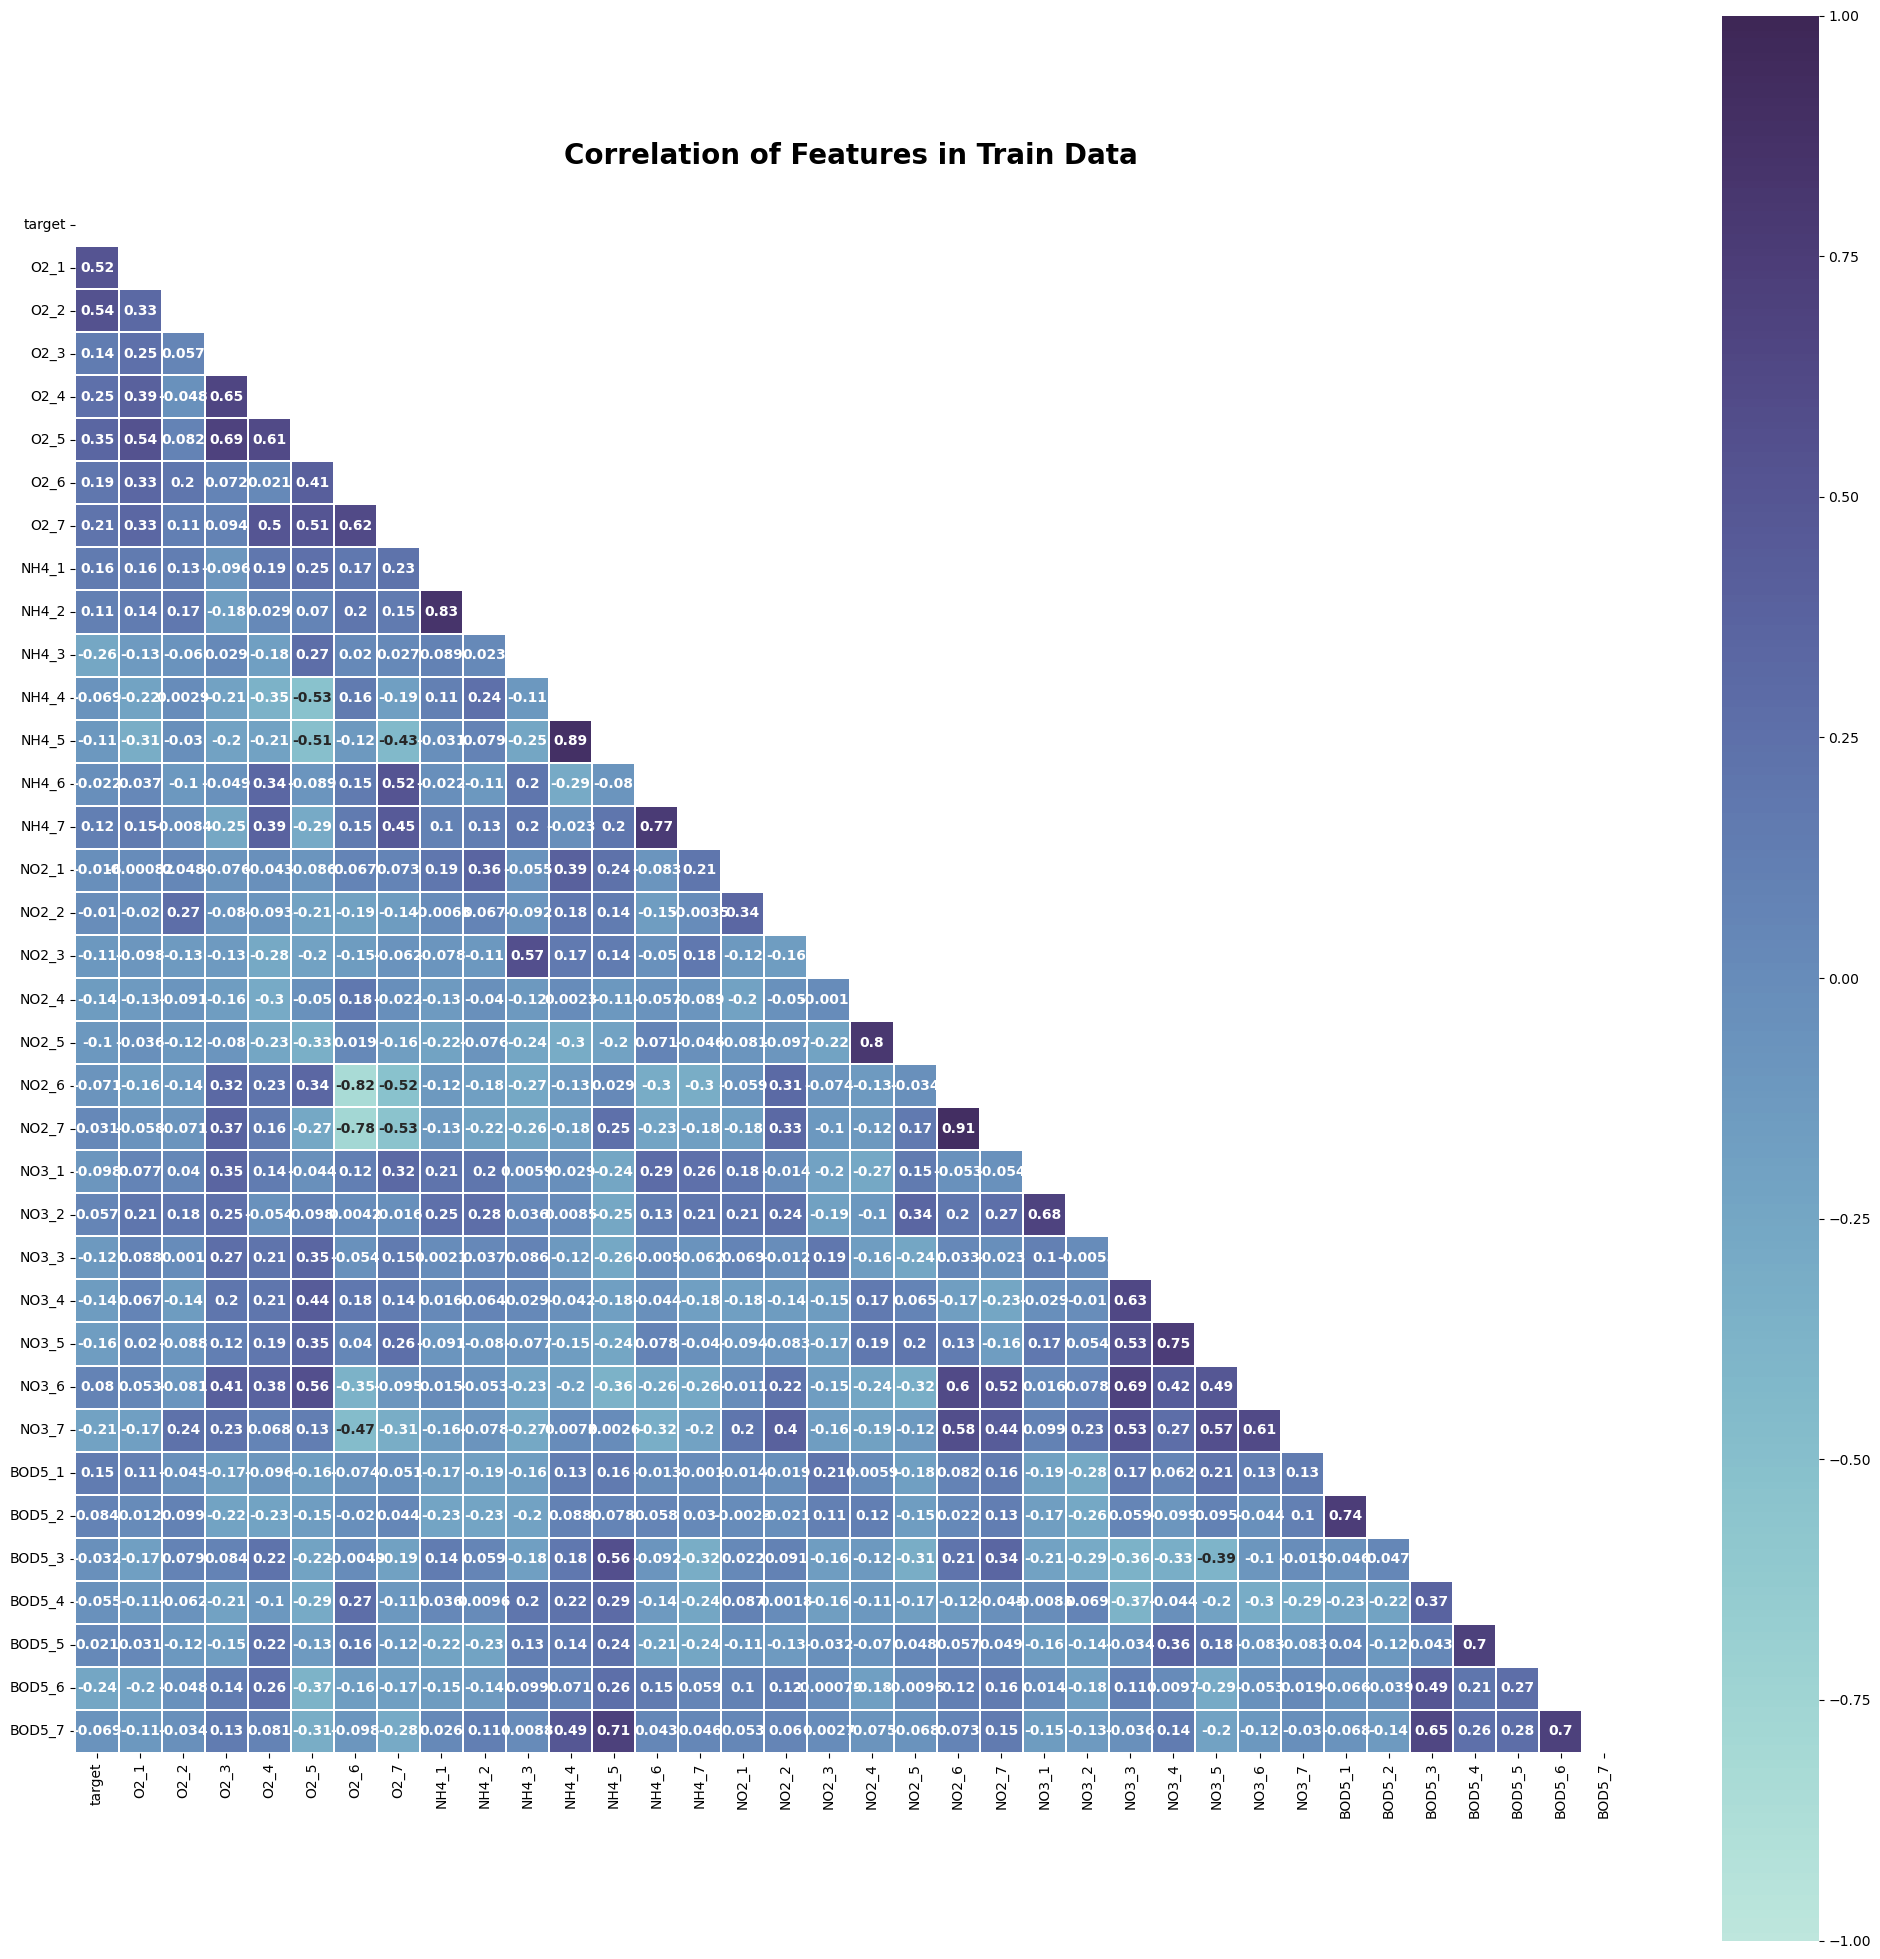

In [7]:
plot_heatmap(train_data.drop(['Id'], axis=1), title='Train Data')


<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">  Preparing the submission data

In [8]:
submission_data = test_data.copy()


<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">  Imputing missing values
</div>

In [9]:
imputer = SimpleImputer(strategy='mean')  
train_data_imputed = imputer.fit_transform(train_data.drop(['Id'], axis=1))
train_data_imputed = pd.DataFrame(train_data_imputed, columns=train_data.columns[1:])


<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">  Inspecting columns of training data
</div>

In [10]:
train_data.columns

Index(['Id', 'target', 'O2_1', 'O2_2', 'O2_3', 'O2_4', 'O2_5', 'O2_6', 'O2_7',
       'NH4_1', 'NH4_2', 'NH4_3', 'NH4_4', 'NH4_5', 'NH4_6', 'NH4_7', 'NO2_1',
       'NO2_2', 'NO2_3', 'NO2_4', 'NO2_5', 'NO2_6', 'NO2_7', 'NO3_1', 'NO3_2',
       'NO3_3', 'NO3_4', 'NO3_5', 'NO3_6', 'NO3_7', 'BOD5_1', 'BOD5_2',
       'BOD5_3', 'BOD5_4', 'BOD5_5', 'BOD5_6', 'BOD5_7'],
      dtype='object')

<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">  Defining the columns for the features and target
</div>

In [11]:
feature_columns = ['O2_1', 'O2_2', 'O2_3', 'O2_4', 'O2_5', 'O2_6', 'O2_7']
target_column = 'target'

train = train_data[feature_columns].copy()
y_train = train_data[target_column]


<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> Impute missing values in the training data

</div>

In [12]:
imputer = SimpleImputer(strategy='mean')
train = imputer.fit_transform(train)


<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">  Initializing the random forest regressor with Optuna based hyper param over K fold CV
</div>

In [13]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5)
    }
    
    mae_scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_index, valid_index in kf.split(train):
        X_train, X_valid = train[train_index], train[valid_index]
        y_train_split, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
        
        rf = RandomForestRegressor(**params, n_jobs=-1, random_state=42)
        rf.fit(X_train, y_train_split)
        y_pred_valid = rf.predict(X_valid)
        
        mae = mean_absolute_error(y_valid, y_pred_valid)
        mae_scores.append(mae)
    
    return sum(mae_scores) / len(mae_scores)

<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">  Creating an Optuna study object and optimize

</div>

In [14]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)


[I 2023-08-23 11:09:03,045] A new study created in memory with name: no-name-4f37a10f-828f-4b01-b351-56939c336be4
[I 2023-08-23 11:09:09,541] Trial 0 finished with value: 2.1852377293970884 and parameters: {'n_estimators': 540, 'max_depth': 11, 'min_samples_split': 0.7297801053128202, 'min_samples_leaf': 0.21855661585357164}. Best is trial 0 with value: 2.1852377293970884.
[I 2023-08-23 11:09:15,316] Trial 1 finished with value: 2.1848646237103053 and parameters: {'n_estimators': 472, 'max_depth': 9, 'min_samples_split': 0.8037543127688466, 'min_samples_leaf': 0.3786057902790708}. Best is trial 1 with value: 2.1848646237103053.
[I 2023-08-23 11:09:25,302] Trial 2 finished with value: 2.1863508042109814 and parameters: {'n_estimators': 836, 'max_depth': 15, 'min_samples_split': 0.7616783641263094, 'min_samples_leaf': 0.4626333592862625}. Best is trial 1 with value: 2.1848646237103053.
[I 2023-08-23 11:09:33,132] Trial 3 finished with value: 2.185165537747552 and parameters: {'n_estimato

<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> Fetching best params & training model on best params
</div>

In [15]:
best_params = study.best_params


In [16]:
rf = RandomForestRegressor(**best_params, n_jobs=-1, random_state=42)
rf.fit(train, y_train)


RandomForestRegressor(max_depth=9, min_samples_leaf=0.10066956938160142,
                      min_samples_split=0.2012960428283977, n_estimators=797,
                      n_jobs=-1, random_state=42)

<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">  Making predictions using trained model
</div>

In [17]:
sample_submission[feature_columns] = sample_submission[feature_columns].fillna(0)  # Fill NaN values with zeros
y_pred = rf.predict(sample_submission[feature_columns])


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">  Updating the submission dataframe with the predictions
</div>

In [18]:
sample_submission[target_column] = y_pred


<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">  Save the submission to a CSV file
</div>

In [19]:
sample_submission.to_csv('submission.csv', index=False)

In [20]:
sample_submission

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.470146,7.500,9.000,9.545,9.265,8.110,8.430,7.150,0.180,...,4.950,1.730,1.800,4.800,3.150,10.665,10.465,16.645,5.750,10.37
1,1,13.124927,13.533,40.900,8.770,9.265,6.015,10.070,7.150,1.107,...,20.050,9.530,7.695,4.550,6.950,2.040,5.200,5.725,2.950,2.23
2,2,6.257899,3.710,5.420,8.770,9.265,4.550,10.070,7.150,0.020,...,4.580,3.025,3.960,4.935,4.950,4.725,6.075,6.750,3.500,3.17
3,3,8.787632,8.700,8.100,9.500,9.200,5.200,8.670,6.670,0.280,...,8.450,2.070,1.730,6.300,4.700,3.500,6.200,8.670,2.900,7.37
4,4,8.482896,8.050,8.650,7.960,9.265,3.290,10.070,7.150,0.360,...,2.020,1.730,0.760,4.800,4.970,3.950,2.800,8.400,3.500,3.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,6.302928,6.250,8.300,7.795,9.265,5.690,8.555,6.335,0.565,...,14.575,0.636,1.640,4.235,4.100,2.800,3.950,7.695,3.540,2.50
3496,3496,6.911900,6.630,6.630,8.370,7.600,0.636,8.430,7.150,1.300,...,4.580,1.730,1.800,4.900,3.150,2.040,6.075,8.415,2.155,2.90
3497,3497,8.529852,8.367,8.433,8.770,6.170,5.800,10.400,7.200,0.430,...,20.050,1.440,1.800,4.867,4.833,4.725,4.950,8.400,6.625,4.20
3498,3498,9.509693,10.000,6.630,9.545,9.265,3.290,8.980,2.310,0.300,...,20.050,9.530,7.695,10.700,5.400,4.725,3.300,6.750,6.625,5.00
